In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import pystan
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

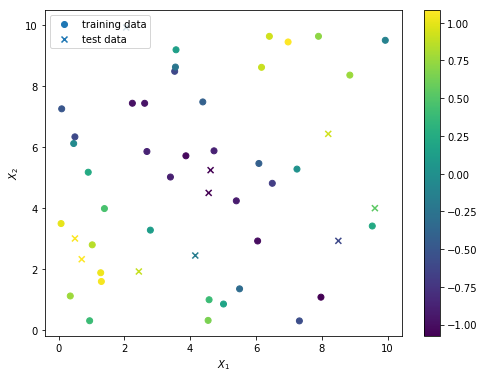

In [3]:
def get_data(N, D, N_test):
    f = lambda x: np.sin(x.mean())
    noise_std = 0.1
    x_min, x_max = 0, 10
    
    X = np.random.uniform(x_min, x_max, size=(N,D))
    y = np.array( [f(x) for x in X] ) + noise_std*np.random.normal(size=N)
    X_test = np.random.uniform(x_min, x_max, size=(N_test,D))
    y_test = np.array( [f(x) for x in X_test] )
    return X, y, X_test, y_test


def plot_data(X, y, X_test, y_test, ax):
    if X.shape[1] == 1: 
        ax.plot(X, y, 'x', label='training data')
        ax.plot(X_test, y_test, 'rx', label='test data')
        ax.set_xlabel('$X$')
        ax.set_ylabel('$y$')
        ax.legend()
    elif X.shape[1] == 2: 
        tmp = ax.scatter(*X.T, c=y, label='training data')
        ax.scatter(*X_test.T, c=y_test, marker='x', label='test data')
        ax.set_xlabel('$X_1$')
        ax.set_ylabel('$X_2$')
        ax.legend()
        plt.colorbar(tmp)
    else: return None
    

    
N, D, N_test = 40, 2, 10
X, y, X_test, y_test = get_data(N, D, N_test)

if D<3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plot_data(X, y, X_test, y_test, ax)
    plt.show()

In [4]:
file = "stan_gp_pred.stan"
with open(file) as f:
    stan_code = f.read()
    
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6779a7019d3727e067303f52cec0587 NOW.


In [5]:
data_dict = dict(N=N, D=D, N_pred=N_test, X=X, y=y, X_pred=X_test)
samples = stan_model.sampling(data_dict)

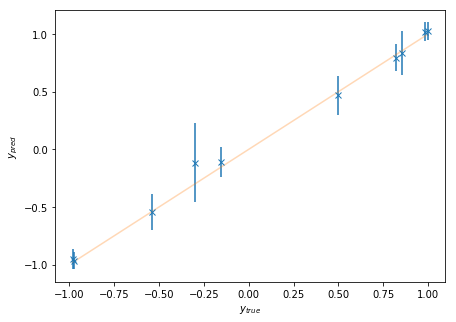

In [6]:
y_pred = samples.extract('y_pred')['y_pred']

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.errorbar(y_test, y_pred.mean(axis=0), yerr=y_pred.std(axis=0), 
             marker='x', linestyle='None')
ax.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), alpha=.3)
ax.set_xlabel('$y_{true}$')
ax.set_ylabel('$y_{pred}$')
plt.show()

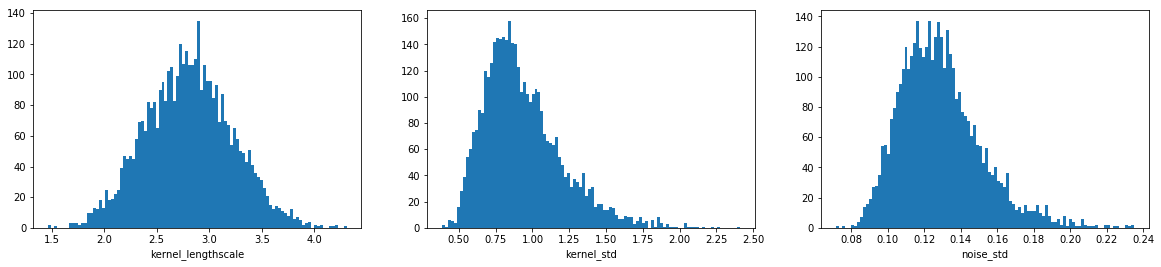

In [7]:
# visualize posterior distribution over Hyperparameter
param = ['kernel_lengthscale', 'kernel_std', 'noise_std',]
param = samples.extract(param)

fig = plt.figure(figsize=(20,4))
for i, (param_name, param_values) in enumerate(param.items()):
    ax = fig.add_subplot(1,len(param),1+i)
    ax.hist(param_values, bins=100)
    ax.set_xlabel(param_name)
plt.show()